In [1]:
#default_exp token2vec

In [2]:
#export
import pandas as pd
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import gensim

import neptune
from github_search import neptune_util

torch.manual_seed(1)

In [3]:
plt.style.use('dark_background')

In [4]:
%cd ..

/home/kuba/Projects/github_search


In [5]:
#export

def get_module_import_corpus(import_corpus_path='data/module_import_corpus.csv'):
    return pd.read_csv(import_corpus_path).iloc[:,1].dropna()

In [6]:
import_corpus = get_module_import_corpus()

In [7]:
import_corpus.head()

0              subprocess shlex re os argparse
1    sys codecs argparse functools collections
2                                     argparse
3         argparse subprocess os shutil re sys
4               argparse collections itertools
Name: 0, dtype: object

# Dataset

TokenDataset allows for sampling `context`, `target` pairs and negative examples as described in Import2Vec paper

In [8]:
#export


class TokenDataset:
    
    def __init__(self, import_corpus, min_import_frequency=10, min_imports=2, use_cuda=True):
        filtered_import_corpus = self._filter_corpus(import_corpus, min_imports)
        self._vectorizer = feature_extraction.text.CountVectorizer(min_df=min_import_frequency, binary=True)
        occurrence_matrix = self._vectorizer.fit_transform(filtered_import_corpus)
        n_imports = np.array((occurrence_matrix.sum(axis=1) > 1)).reshape(-1)
        valid_indices = np.where(n_imports)[0]
        occurrence_matrix = occurrence_matrix[valid_indices,:]
        self._occurrence_matrix = occurrence_matrix
        self.corpus_size = occurrence_matrix.shape[0] 
        self.vocabulary_size = occurrence_matrix.shape[1] 
        self.use_cuda = use_cuda
    
    def sample_imports(self, n_positive_imports, n_negative_imports='same'):
        if n_negative_imports == 'same':
            n_negative_imports = n_positive_imports 
            
        positive_import_contexts, positive_import_targets = self._sample_positive_or_negative_imports(n_positive_imports, positive=True)
        negative_import_contexts, negative_import_targets = self._sample_positive_or_negative_imports(n_negative_imports, positive=False)
        positive_import_contexts, positive_import_targets = torch.tensor(positive_import_contexts), torch.tensor(positive_import_targets) 
        negative_import_contexts, negative_import_targets = torch.tensor(negative_import_contexts), torch.tensor(negative_import_targets)
        predictions = torch.cat(
            (
                torch.ones(n_positive_imports),
                torch.zeros(n_positive_imports)
            ),
            axis=0
        )
        contexts = torch.cat((positive_import_contexts, negative_import_contexts), axis=0)
        targets = torch.cat((positive_import_targets, negative_import_targets), axis=0)
        if self.use_cuda:
            return contexts.cuda(), targets.cuda(), predictions.cuda()
        else:
            return contexts, targets, predictions
        
    def _sample_positive_or_negative_imports(self, n_imports, positive):
        file_indices_sample = np.random.choice(range(self.corpus_size), size=n_imports)
        context_indices = []
        target_indices = []
        for idx in file_indices_sample:
            sample_row = np.array(self._occurrence_matrix[idx].todense())[0]
            import_indices = np.where(sample_row)[0]
            context_index = np.random.choice(import_indices, size=1)[0]
            if positive:
                sample_row[context_index] = 0
                possible_target_indices = np.where(sample_row)[0]
            else:
                possible_target_indices = np.where(sample_row == 0)[0] 
            target_index = np.random.choice(possible_target_indices)
            context_indices.append(context_index)
            target_indices.append(target_index)
        return context_indices, target_indices
    
    def _filter_corpus(self, import_corpus, min_imports):
        return import_corpus[import_corpus.str.split().apply(set).apply(len) >= min_imports]

In [9]:
small_import_corpus = [
    'pandas numpy',
    'numpy seaborn',
    'pandas tensorflow',
    'tensorflow seaborn',
    'pandas seaborn'
]

In [10]:
small_import_dataset = TokenDataset(pd.Series(small_import_corpus), min_import_frequency=1)
assert small_import_dataset.corpus_size == 5
assert small_import_dataset.vocabulary_size == 4
assert small_import_dataset._occurrence_matrix.sum() == 10

In [11]:
#export


class Token2Vec(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super(Token2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, context, target):
        context_embeddings = self.embeddings(context)
        target_embeddings = self.embeddings(target)
        similarities = (context_embeddings * target_embeddings).sum(axis=1) 
        return similarities

In [12]:
#export


class Token2VecModeler:
    
    def __init__(self, token_dataset, embedding_size, use_cuda=True):
        self.token_dataset = token_dataset
        self.token2vec = Token2Vec(token_dataset.vocabulary_size, embedding_size)
        if use_cuda:
            self.token2vec.cuda()
        
    def fit(
            self,
            n_positive_imports,
            n_iterations,
            lr=0.001,
            loss_function=nn.BCEWithLogitsLoss(),
            evaluation_period=100,
            optimizer_cls=optim.Adam):
        losses = []
        eval_losses = []
        self.loss_function = nn.BCEWithLogitsLoss()
        optimizer = optimizer_cls(self.token2vec.parameters(), lr=0.001)
        self.optimizer = optimizer

        for iteration in tqdm.tqdm(range(n_iterations)):
            training_loss = self._get_sample_loss(n_positive_imports, training=True, optimizer=optimizer)
            neptune.log_metric('training_loss', training_loss)
            losses.append(training_loss)
            if iteration % evaluation_period == 0:
                valid_loss = self._get_sample_loss(n_positive_imports, training=False)
                eval_losses.append(valid_loss)
                neptune.log_metric('eval_loss', valid_loss)
            
        history = {'train_loss': losses, 'eval_loss': eval_losses}
        return history
    
    def _get_sample_loss(self, n_positive_imports, training, optimizer=None):
        (context, target, pred) = self.token_dataset.sample_imports(n_positive_imports=n_positive_imports)
        self.token2vec.zero_grad()
        log_probs = self.token2vec(context, target)

        loss = self.loss_function(log_probs, pred)
        total_loss = 0
        total_loss += loss.item()
        if training: 
            loss.backward()
            optimizer.step()
        return total_loss

    def make_keyed_vectors(self):
        vocab = self.token_dataset._vectorizer.vocabulary_
        word_vectors = self.token2vec.embeddings.weight.cpu().detach().numpy()
        kv = gensim.models.KeyedVectors(word_vectors.shape[1])
        words_list = list(vocab.keys())
        vectors = []
        for word in words_list:
            vectors.append(word_vectors[vocab[word]])
        kv.add(words_list, vectors)
        return kv


In [13]:
import_dataset = TokenDataset(import_corpus)

In [14]:
embedding_dim = 100

In [15]:
token2vec_modeler = Token2VecModeler(import_dataset, embedding_dim)

In [16]:
n_iterations = 1000
n_positive_imports = 32

In [17]:
sampled_files_ratio = n_positive_imports * n_iterations / import_dataset.corpus_size

In [18]:
sampled_tokens_ratio = n_positive_imports * n_iterations / import_dataset.vocabulary_size

In [19]:
sampled_files_ratio, sampled_tokens_ratio

(0.11645553036395992, 10.168414362885288)

In [20]:
hyperparameters = dict(
    n_iterations=n_iterations,
    n_positive_imports=n_positive_imports,
    embedding_dim=embedding_dim,
    lr=0.001
)

In [21]:
neptune_util.init_neptune('import2vec', params=hyperparameters)

https://ui.neptune.ai/lambdaofgod/github-search/e/GIT-1


In [22]:
history = token2vec_modeler.fit(n_positive_imports, n_iterations, lr=0.001) 

100%|██████████| 1000/1000 [00:47<00:00, 21.01it/s]


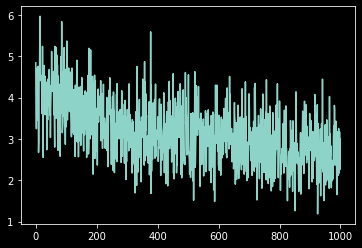

In [24]:
plt.plot(history['train_loss']);

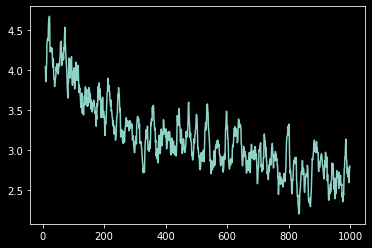

In [25]:
plt.plot(pd.Series(history['train_loss']).rolling(10).mean());

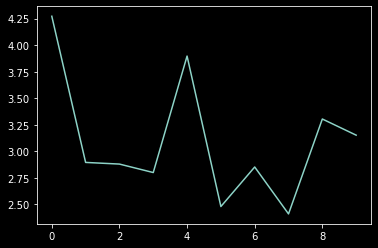

In [26]:
plt.plot(history['eval_loss']);

In [27]:
import_dataset._vectorizer.vocabulary_

{'subprocess': 2671,
 'shlex': 2522,
 're': 2255,
 'os': 1932,
 'argparse': 101,
 'sys': 2692,
 'codecs': 409,
 'functools': 1071,
 'collections': 419,
 'shutil': 2526,
 'itertools': 1349,
 'copy': 550,
 'io': 1333,
 'numpy': 1873,
 'translate': 2945,
 'math': 1567,
 'matplotlib': 1569,
 'random': 2242,
 'sklearn': 2559,
 'scipy': 2444,
 'string': 2660,
 'signal': 2530,
 'contextlib': 523,
 'tempfile': 2720,
 'logging': 1504,
 'struct': 2666,
 'tensorflow': 2726,
 'yaml': 3133,
 'tarfile': 2708,
 'pprint': 2063,
 'operator': 1904,
 'pickle': 2007,
 'time': 2821,
 'wave': 3078,
 'heapq': 1221,
 'torch': 2870,
 'torchvision': 2891,
 'pil': 2009,
 'utils': 3002,
 'models': 1699,
 'tensorboardx': 2725,
 'option': 1924,
 'framework': 1053,
 'data': 630,
 'quantization': 2228,
 'pyhocon': 2161,
 'datetime': 672,
 'json': 1367,
 'cv2': 609,
 'config': 453,
 'model': 1656,
 'dataset': 663,
 'tqdm': 2898,
 'transforms': 2941,
 'abc': 0,
 'keras': 1376,
 'utils_logging': 3005,
 'pandas': 1947,
 

In [28]:
keyed_vectors = token2vec_modeler.make_keyed_vectors()

In [29]:
optimizer_name = token2vec_modeler.optimizer.__class__.__name__
keyed_vectors.save('data/import2vec_module_vectors_{}_dim{}_bs{}.bin'.format(optimizer_name, embedding_dim, n_positive_imports))